In [ ]:
#import required libraries
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
#from keras.applications.resnet import ResNet50, ResNet101, preprocess_input
#from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet import ResNet50, ResNet101, preprocess_input  # Uncomment if using these models

# from keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras import Model, layers, regularizers
from keras.metrics import Precision, Recall
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import AUC
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import pandas as pd
# import splitfolders
import numpy as np
import shutil
import glob
import os

sns.set()

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Useful Functions

In [ ]:
# HELPER FUNCTION

#function to count images in subfolders:
def count_images(base_dir):
  allFiles = 0
  for subdir in os.listdir(base_dir):
      subdir_path = os.path.join(base_dir, subdir)
      if os.path.isdir(subdir_path):
          num_files = len(os.listdir(subdir_path))
          print(f"{num_files} files in subdirectory {subdir}.")
      allFiles = allFiles + num_files
  print(f"Total: {allFiles} files.")


def generators(shape, preprocessing, train_dir, val_dir, test_dir, batch_size):
  #create training and validation datasets of given image shape

    imgDatagen= ImageDataGenerator(
      preprocessing_function = preprocessing
    )

    height, width = shape

    train_dataset = imgDatagen.flow_from_directory(
      train_dir,
      target_size = (height, width),
      class_mode= 'categorical',
      batch_size = batch_size,
      shuffle=True
    )

    val_dataset = imgDatagen.flow_from_directory(
      val_dir,
      target_size = (height, width),
      class_mode= 'categorical',
      batch_size = batch_size,
      shuffle=True
    )

    test_dataset = imgDatagen.flow_from_directory(
      test_dir,
      target_size = (height, width),
      class_mode= 'categorical',
      batch_size = batch_size,
      shuffle=False
    )

    return train_dataset, val_dataset, test_dataset

def generators_train_val(shape, preprocessing, train_dir, val_dir, batch_size):
  #create training and validation datasets of given image shape

    imgDatagen= ImageDataGenerator(
      preprocessing_function = preprocessing
    )

    height, width = shape

    train_dataset = imgDatagen.flow_from_directory(
      train_dir,
      target_size = (height, width),
      class_mode= 'categorical',
      batch_size = batch_size,
      shuffle=True
    )

    val_dataset = imgDatagen.flow_from_directory(
      val_dir,
      target_size = (height, width),
      class_mode= 'categorical',
      batch_size = batch_size,
      shuffle=True
    )

    # test_dataset = imgDatagen.flow_from_directory(
    #   test_dir,
    #   target_size = (height, width),
    #   class_mode= 'categorical',
    #   batch_size = batch_size,
    #   shuffle=False
    # )

    return train_dataset, val_dataset

def generator_test(shape, preprocessing, test_dir, batch_size):
  #create training and validation datasets of given image shape

    imgDatagen= ImageDataGenerator(
      preprocessing_function = preprocessing
    )

    height, width = shape

    test_dataset = imgDatagen.flow_from_directory(
      test_dir,
      target_size = (height, width),
      class_mode= 'categorical',
      batch_size = batch_size,
      shuffle=False
    )

    return test_dataset

#function to plot accuracy and loss graphs:
def plot_acc_loss_graphs(model):
  auc_score = model.history.history['auc']
  val_auc_score = model.history.history['val_auc']
  loss =  model.history.history['loss']
  val_loss = model.history.history['val_loss']

  epochs = range(len(loss))

  # create a figure with 1 row and 3 columns
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

  for ax in axes:
      ax.set_facecolor('lightgray')
      ax.set_xlabel('epochs')
      ax.spines['top'].set_visible(False)
      ax.spines['right'].set_visible(False)
      ax.spines['bottom'].set_visible(False)
      ax.spines['left'].set_visible(False)

  # Plot training and validation auc
  axes[0].plot(epochs, auc_score, color='crimson', label='Training AUC score')
  axes[0].plot(epochs, val_auc_score, color='darkgreen', label='Validation AUC score')
  axes[0].set_ylabel('score')
  axes[0].set_title('Training and Validation Accuracy')
  axes[0].legend()
  axes[0].grid()


  # Plot training and validation loss
  axes[1].plot(epochs, loss, color='crimson', label='Training loss')
  axes[1].plot(epochs, val_loss, color='darkgreen', label='Validation loss')
  axes[1].set_ylabel('loss')
  axes[1].set_title('Training and Validation Loss')
  axes[1].legend()
  axes[0].grid()

  plt.show()


#function to plot classification report, AUROC and confusion matrix

def plot_evaluation_graphs(y_pred, test_dataset):
  true_images, true_labels = next(test_dataset)

  pred_rn = pd.get_dummies(np.argmax(y_pred, axis=-1)).to_numpy().astype(np.float32)

  # classification report
  print(classification_report(true_labels, pred_rn, target_names=classes))

  for label in range(class_count):
    fpr,tpr,thresholds = roc_curve(true_labels[:,label], y_pred[:,label])
    roc_auc = roc_auc_score(true_labels[:,label], y_pred[:,label])

  # create a figure with 1 row and 3 columns
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

  # evaluation results
  axes[0].plot([0,1],[0,1],'k:',label='Random')
  axes[0].plot(fpr, tpr, label='ROC curve for class {0} (AUC = {1:0.2f})'.format(classes[label], roc_auc))
  axes[0].set_xlabel('False Positive Rate')
  axes[0].set_ylabel('True Positive Rate')
  axes[0].set_title('AUROC metrics')
  axes[0].legend()
  axes[0].grid()

  # Confusion matrix results
  matrix = confusion_matrix(np.argmax(true_labels, axis=-1), np.argmax(pred_rn, axis=-1)) ## pred_x
  cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=classes)
  cm_display.plot(ax=axes[1])
  axes[1].set_title('Confusion Matrix')
  axes[1].grid(False)

  plt.show()


#functions to view sample images

def view_5_images(x, y, p, classes):
    indices = range(5)

    x = x[indices]
    y = y[indices]
    p = p[indices]

    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(1, 5, 1 +i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(classes[np.argmax(p[i])], color=col)
    plt.show()

def view_10_images(x, y, p, classes):
    indices = range(10)

    x = x[indices]
    y = y[indices]
    p = p[indices]

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, 1 +i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(classes[np.argmax(p[i])], color=col)
    plt.show()

def view_2_images(x, y, p, classes):
    plt.figure(figsize=(10, 5))

    for class_index, class_name in enumerate(classes):
        # Select first two images for this class
        class_indices = np.where(np.argmax(y, axis=1) == class_index)[0][:2]

        for i, index in enumerate(class_indices):
            plt.subplot(2, 5, class_index+1+i*5)
            plt.imshow(x[index])
            plt.xticks([])
            plt.yticks([])
            col = 'green' if np.argmax(y[index]) == np.argmax(p[index]) else 'red'
            plt.xlabel(classes[np.argmax(p[index])], color=col)

    plt.tight_layout()
    plt.show()



#####
#predicted results

def get_dataframe_results(y_pred, saved_model, ds_test):
  # Get the predicted class (0 or 1)
  y_pred = saved_model.predict(ds_test, verbose=1)

  # Get the list of image filenames from the generator
  image_filenames = ds_test.filepaths

  # Get the predicted class (0 or 1)
  predicted_classes = np.argmax(y_pred, axis=1)

  # Create a DataFrame with image filenames and predicted class
  df_results = pd.DataFrame({
      'Image_Filename': image_filenames,
      'Predicted_Class': predicted_classes,
      'Prediction_0': y_pred[:, 0],
      'Prediction_1': y_pred[:, 1]
      # Add other columns if needed, depending on your data
  })
  return df_results

  #separate into training folders

def move_predicted_images_into_folders(folder_b, folder_m, df_results):
  # Create folders if they don't exist
  for folder in [folder_b, folder_m]:
      os.makedirs(folder, exist_ok=True)

  # Iterate through the DataFrame and move images based on predicted class
  for index, row in df_results.iterrows():
      image_filename = row['Image_Filename']
      predicted_class = row['Predicted_Class']

      if predicted_class == 0:
          destination_folder = folder_b
      elif predicted_class == 1:
          destination_folder = folder_m
      else:
          # Handle other cases if needed
          continue

      # Construct the destination path
      destination_path = os.path.join(destination_folder, os.path.basename(image_filename))

      # Move the file
      shutil.copy(image_filename, destination_path)

  print("Images moved successfully.")

def copy_jpg_images(source_folder, destination_folder):
    # Ensure the source folder exists
    if not os.path.exists(source_folder):
        print(f"Source folder '{source_folder}' does not exist.")
        return

    # Ensure the destination folder exists, create it if not
    os.makedirs(destination_folder, exist_ok=True)

    # Iterate through files in the source folder
    for file in os.listdir(source_folder):
        source_path = os.path.join(source_folder, file)

        # Check if the file is a JPG image
        if file.lower().endswith('.jpg'):
            destination_path = os.path.join(destination_folder, file)

            # Copy the file to the destination folder
            shutil.copy2(source_path, destination_path)

    print("Images copied successfully.")

def count_images_in_folder(folder_path):
    # Ensure the folder path exists
    if not os.path.exists(folder_path):
        print(f"Folder '{folder_path}' does not exist.")
        return 0

    # Get the list of files in the folder
    files = os.listdir(folder_path)

    # Filter only files (not directories)
    image_files = [file for file in files if os.path.isfile(os.path.join(folder_path, file))]

    # Count the number of image files
    num_images = len(image_files)

    return num_images


#Load Dataset

In [ ]:
all_labels_df = pd.read_csv(r'/content/drive/MyDrive/All mixed/all_data_labels_loc_aug.csv')
all_labels_df.shape

(956, 3)

In [ ]:
all_labels_df

,filename,label,folder_location
0,benign (102),benign,cairo
1,benign (112),benign,cairo
2,benign (114),benign,cairo
3,benign (115),benign,cairo
4,benign (155),benign,cairo
...,...,...,...
951,flipped_patient86_RT_bi2,benign,ecurei
952,flipped_patient56_LT_1_bi2,benign,ecurei
953,flipped_patient12_bi2,benign,ecurei
954,flipped_patient13_bi2,benign,ecurei


In [ ]:
parent_dir = r'/content/drive/MyDrive/All mixed/cls/wsl/round1'
classes = ['benign', 'malignant']
split_data=['test','train','val']
class_count=len(classes)
classes_map = dict(zip(classes,range(len(classes)))) #{'benign': 0, 'malignant': 1}

for i in split_data:
  class_dict = {key:len(glob.glob(f'{parent_dir}/{i}/{key}/*.jpg')) for key in classes}

In [ ]:
for i in split_data:
  print(i)
  class_dict = {key:len(glob.glob(f'{parent_dir}/{i}/{key}/*.jpg')) for key in classes}
  print( {key:len(glob.glob(f'{parent_dir}/{i}/{key}/*.jpg')) for key in classes})

test
{'benign': 131, 'malignant': 131}
train
{'benign': 130, 'malignant': 130}
val
{'benign': 67, 'malignant': 67}


In [ ]:
print(f'class map: {classes_map} and class dictionary: {class_dict} of {class_count} classes')

class map: {'benign': 0, 'malignant': 1} and class dictionary: {'benign': 67, 'malignant': 67} of 2 classes


#Setup folders

In [ ]:
train_dir='/content/drive/MyDrive/All mixed/cls/wsl/round1/train'
val_dir='/content/drive/MyDrive/All mixed/cls/wsl/round1/val'
test_dir='/content/drive/MyDrive/All mixed/cls/wsl/round1/test'

In [ ]:
count_images(train_dir)
count_images(val_dir)
count_images(test_dir)

130 files in subdirectory malignant.
130 files in subdirectory benign.
Total: 260 files.
67 files in subdirectory malignant.
67 files in subdirectory benign.
Total: 134 files.
131 files in subdirectory malignant.
131 files in subdirectory benign.
Total: 262 files.


#**WSL ROUND ONE**

#ResNet50

###Create and preprocess datasets

In [ ]:
#preprocess the datasets
ds_train_rn, ds_val_rn = generators_train_val((224,224), preprocess_input, train_dir, val_dir,8)
ds_test_rn=generator_test((224,224), preprocess_input, test_dir,262)

Found 260 images belonging to 2 classes.
Found 134 images belonging to 2 classes.
Found 262 images belonging to 2 classes.


###Train, Compile & Fit Model

In [ ]:
pre_trained_model_rs = Sequential();

pre_trained_model_rs = ResNet50(input_shape=(224,224, 3),
                             include_top = False,
                             weights = 'imagenet',
                             pooling='avg',
                             classes=2
                             )

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
# Freeze layers
for layer in pre_trained_model_rs.layers:
  layer.trainable = False

x = pre_trained_model_rs.output
# x = layers.Flatten()(x)
# # x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
# # x = layers.BatchNormalization()
x = layers.Dropout(0.5)(x)
output= layers.Dense(class_count, activation='softmax')(x)

#resnet50 model
resnet_model = Model(inputs=pre_trained_model_rs.input, outputs=output)

In [ ]:
#model architecture
#resnet_model.summary()

In [ ]:
# Compile model
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[AUC(name='auc')]
              )

# Train model
resnet_model.fit(ds_train_rn,
          validation_data=ds_val_rn,
          epochs=200,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=50),
                    #  tf.keras.callbacks.ModelCheckpoint(monitor='val_auc')
                     ]
          )

Epoch 1/200
33/33 [==============================] - 7s 99ms/step - loss: 0.7257 - auc: 0.7820 - val_loss: 0.5793 - val_auc: 0.8740
Epoch 2/200
33/33 [==============================] - 2s 65ms/step - loss: 0.3819 - auc: 0.9068 - val_loss: 0.3664 - val_auc: 0.9179
Epoch 3/200
33/33 [==============================] - 2s 62ms/step - loss: 0.2619 - auc: 0.9573 - val_loss: 0.3590 - val_auc: 0.9264
Epoch 4/200
33/33 [==============================] - 2s 62ms/step - loss: 0.3256 - auc: 0.9348 - val_loss: 0.3531 - val_auc: 0.9248
Epoch 5/200
33/33 [==============================] - 2s 63ms/step - loss: 0.2772 - auc: 0.9523 - val_loss: 0.3614 - val_auc: 0.9277
Epoch 6/200
33/33 [==============================] - 2s 63ms/step - loss: 0.1972 - auc: 0.9766 - val_loss: 0.3892 - val_auc: 0.9221
Epoch 7/200
33/33 [==============================] - 2s 64ms/step - loss: 0.2027 - auc: 0.9748 - val_loss: 0.3507 - val_auc: 0.9319
Epoch 8/200
33/33 [==============================] - 2s 67ms/step - loss: 0.

###Performance

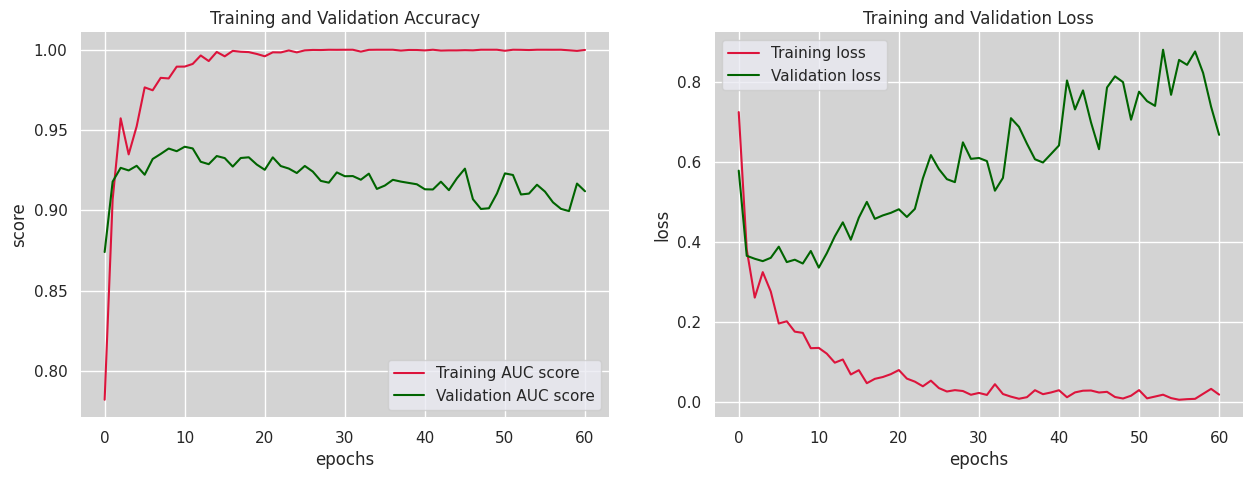

In [ ]:
plot_acc_loss_graphs(resnet_model)

###Evaluation

In [ ]:
##Evaluation
# resnet_model.save('/content/drive/MyDrive/Research/models/resnet_model_ai.h5')
# Assuming 'model' is your TensorFlow model
resnet_model.save("/content/drive/MyDrive/All mixed/cls/wsl/round1/resnet50_model_02.h5")
#load the model:
# saved_resnet_model = tf.keras.models.load_model('/content/drive/MyDrive/Research/models/resnet_model_ai.h5');

In [ ]:
resnet_model = tf.keras.models.load_model('/content/drive/MyDrive/All mixed/cls/wsl/round1/resnet50_model_02.h5')

In [ ]:
y_pred_rn = resnet_model.predict(ds_test_rn, verbose=1)
print(f'y_pred_shape:{y_pred_rn.shape} and shape[0] is: {y_pred_rn.shape[0]}')

1/1 [==============================] - 18s 18s/step
y_pred_shape:(262, 2) and shape[0] is: 262


              precision    recall  f1-score   support

      benign       0.86      0.92      0.89       131
   malignant       0.91      0.85      0.88       131

   micro avg       0.89      0.89      0.89       262
   macro avg       0.89      0.89      0.89       262
weighted avg       0.89      0.89      0.89       262
 samples avg       0.89      0.89      0.89       262



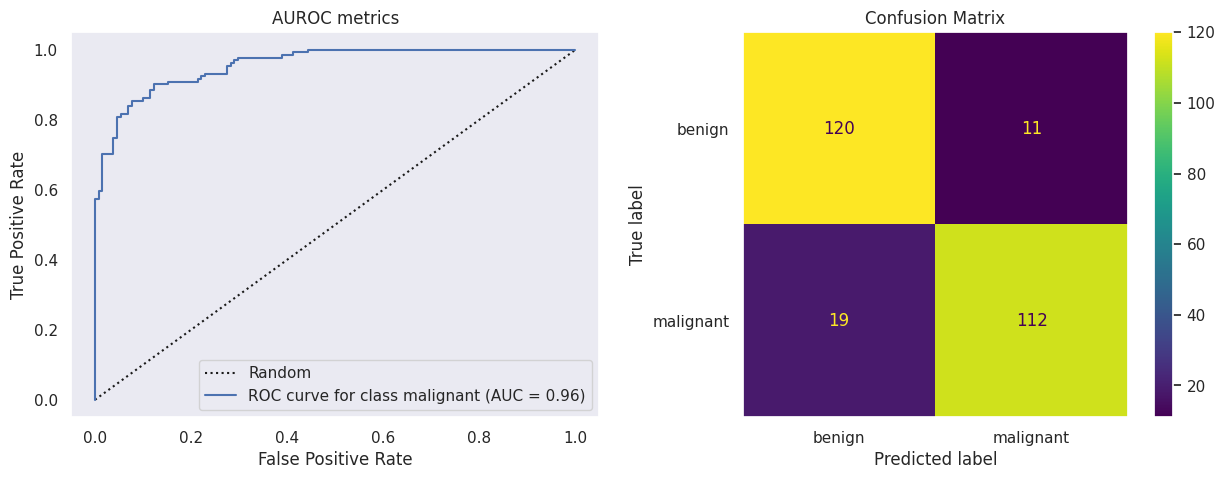

In [ ]:
plot_evaluation_graphs(y_pred_rn, ds_test_rn)

###Smaller generator - TAKEN

####Create and preprocess datasets

In [ ]:
import torch
from torch.utils.data import ConcatDataset, DataLoader

In [ ]:
test_dir='/content/drive/MyDrive/All mixed/cls/wsl/round2/test'

In [ ]:
#preprocess the datasets
ds_train_sm_rn, ds_val_sm_rn = generators_train_val((224,224), preprocess_input, train_dir, val_dir, 16)
ds_test_sm_rn = generator_test((224,224), preprocess_input, test_dir, 262)

Found 260 images belonging to 2 classes.
Found 134 images belonging to 2 classes.
Found 70 images belonging to 2 classes.


####Train, Compile & Fit Model

In [ ]:
pre_trained_model_rs = Sequential();

pre_trained_model_rs = ResNet50(input_shape=(224,224, 3),
                             include_top = False,
                             weights = 'imagenet',
                             pooling='avg',
                             classes=2
                             )

In [ ]:
# Freeze layers
for layer in pre_trained_model_rs.layers:
  layer.trainable = False

x = pre_trained_model_rs.output
x = layers.Flatten()(x)
# # x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
# # x = layers.BatchNormalization()
x = layers.Dropout(0.5)(x)
output= layers.Dense(class_count, activation='softmax')(x)

#resnet50 model
resnet_model = Model(inputs=pre_trained_model_rs.input, outputs=output)

In [ ]:
#model architecture
resnet_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
# Compile model
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[AUC(name='auc')]
              )

# Train model
resnet_model.fit(ds_train_sm_rn,
          validation_data=ds_val_sm_rn,
          epochs=200,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=3),
                    #  tf.keras.callbacks.ModelCheckpoint(monitor='val_auc')
                     ]
          )

Epoch 1/200
17/17 [==============================] - 99s 5s/step - loss: 0.8058 - auc: 0.5649 - val_loss: 0.5413 - val_auc: 0.8381
Epoch 2/200
17/17 [==============================] - 2s 129ms/step - loss: 0.6276 - auc: 0.7184 - val_loss: 0.4648 - val_auc: 0.8981
Epoch 3/200
17/17 [==============================] - 3s 162ms/step - loss: 0.4656 - auc: 0.8662 - val_loss: 0.4345 - val_auc: 0.9033
Epoch 4/200
17/17 [==============================] - 3s 162ms/step - loss: 0.4204 - auc: 0.9005 - val_loss: 0.4114 - val_auc: 0.9087
Epoch 5/200
17/17 [==============================] - 5s 283ms/step - loss: 0.4089 - auc: 0.8997 - val_loss: 0.3926 - val_auc: 0.9113
Epoch 6/200
17/17 [==============================] - 2s 128ms/step - loss: 0.3904 - auc: 0.9128 - val_loss: 0.3807 - val_auc: 0.9160
Epoch 7/200
17/17 [==============================] - 2s 129ms/step - loss: 0.4012 - auc: 0.9020 - val_loss: 0.3753 - val_auc: 0.9145
Epoch 8/200
17/17 [==============================] - 2s 129ms/step - lo

####Performance

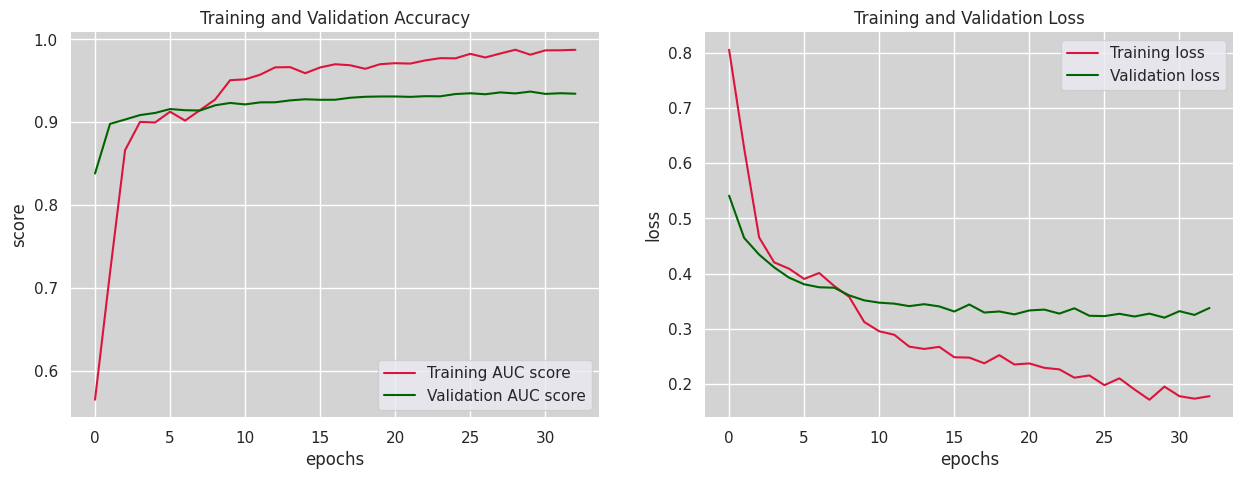

In [ ]:
plot_acc_loss_graphs(resnet_model)

####Evaluation

In [ ]:
##Evaluation
# resnet_model.save('/content/drive/MyDrive/Research/models/resnet_model_ai.h5')
# Assuming 'model' is your TensorFlow model
# resnet_model.save("/content/drive/MyDrive/Research/models/resnet50_sm_wsl_model_03.h5")
#load the model:
saved_resnet_model = tf.keras.models.load_model('/content/drive/MyDrive/Research/models/resnet50_sm_wsl_model_03.h5');

In [ ]:
y_pred_rn = saved_resnet_model.predict(ds_test_sm_rn, verbose=1)
print(f'y_pred_shape:{y_pred_rn.shape} and shape[0] is: {y_pred_rn.shape[0]}')

1/1 [==============================] - 15s 15s/step
y_pred_shape:(262, 2) and shape[0] is: 262


In [ ]:
true_images_rn, true_labels_rn = ds_test_sm_rn.next()

In [ ]:
true_images_rn.shape

(262, 224, 224, 3)

              precision    recall  f1-score   support

      benign       0.81      0.92      0.86       131
   malignant       0.91      0.79      0.84       131

   micro avg       0.85      0.85      0.85       262
   macro avg       0.86      0.85      0.85       262
weighted avg       0.86      0.85      0.85       262
 samples avg       0.85      0.85      0.85       262



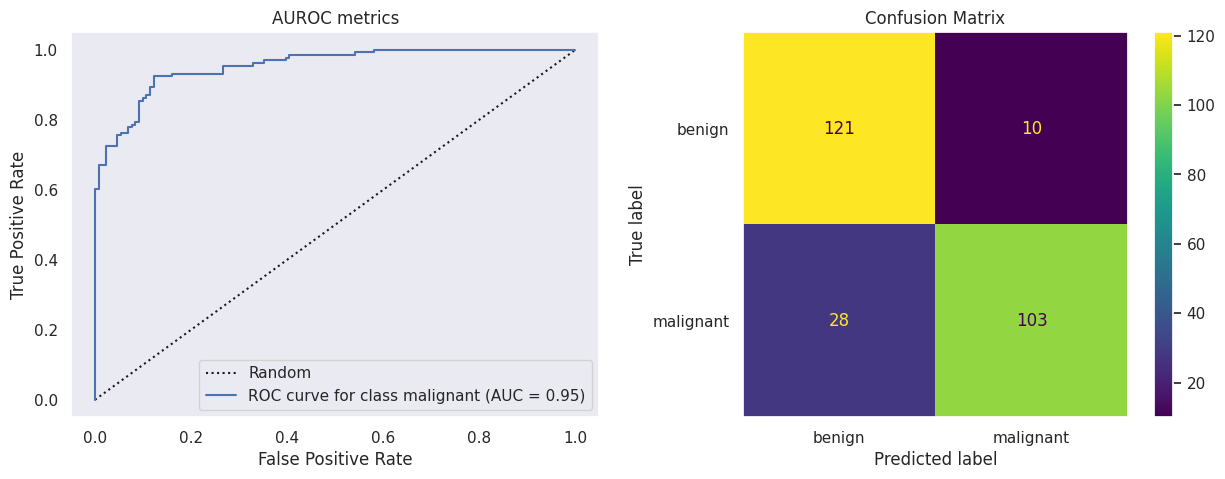

In [ ]:
plot_evaluation_graphs(y_pred_rn, ds_test_sm_rn)

In [ ]:
y_pred_rn.shape

(262, 2)

#MobileNet

##Create and preprocess datasets

In [ ]:
# def preprocess_mn(images, labels):
#   return tf.keras.applications.mobilenet.preprocess_input(images), labels

In [ ]:
ds_train_mn, ds_val_mn = generators_train_val((224,224), tf.keras.applications.mobilenet.preprocess_input, train_dir, val_dir,8)
ds_test_mn = generator_test((224,224), tf.keras.applications.mobilenet.preprocess_input, test_dir, 262)

Found 260 images belonging to 2 classes.
Found 134 images belonging to 2 classes.
Found 262 images belonging to 2 classes.


##Train

In [ ]:
pre_trained_model_mn= Sequential();

pre_trained_model_mn = tf.keras.applications.MobileNet(input_shape=(224,224, 3),  ##
                             include_top = False,
                             weights = 'imagenet',
                             pooling='avg',
                             classes=2
                             )

# Freeze layers
for layer in pre_trained_model_mn.layers: ##
  layer.trainable = False

x = pre_trained_model_mn.output ##
x = layers.Flatten()(x)
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dense(512, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output= layers.Dense(class_count, activation='softmax')(x)

#mobile model
mobileNet_model = Model(pre_trained_model_mn.input, output) ##

In [ ]:
# Compile model
mobileNet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[AUC(name='auc')]
              )

# Train model
mobileNet_model.fit(ds_train_mn, ##
          validation_data=ds_val_mn, ##
          epochs=200,
          # callbacks=callback_params,
          # class_weight=class_weights,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=15),
                    #  tf.keras.callbacks.ModelCheckpoint('models/mobileNet_ai_{val_auc:.3f}.h5',
                    #                                     save_best_only=True,
                    #                                     save_weights_only=False,
                    #                                     monitor='val_auc')
                     ]
          )

Epoch 1/200
33/33 [==============================] - 94s 3s/step - loss: 0.9041 - auc: 0.5759 - val_loss: 0.5470 - val_auc: 0.7959
Epoch 2/200
33/33 [==============================] - 2s 68ms/step - loss: 0.6367 - auc: 0.7406 - val_loss: 0.4494 - val_auc: 0.8845
Epoch 3/200
33/33 [==============================] - 2s 71ms/step - loss: 0.5183 - auc: 0.8234 - val_loss: 0.4147 - val_auc: 0.9003
Epoch 4/200
33/33 [==============================] - 2s 73ms/step - loss: 0.4900 - auc: 0.8396 - val_loss: 0.3850 - val_auc: 0.9147
Epoch 5/200
33/33 [==============================] - 3s 81ms/step - loss: 0.4289 - auc: 0.8757 - val_loss: 0.3729 - val_auc: 0.9193
Epoch 6/200
33/33 [==============================] - 2s 73ms/step - loss: 0.3476 - auc: 0.9283 - val_loss: 0.3713 - val_auc: 0.9162
Epoch 7/200
33/33 [==============================] - 2s 68ms/step - loss: 0.3658 - auc: 0.9184 - val_loss: 0.3540 - val_auc: 0.9236
Epoch 8/200
33/33 [==============================] - 3s 84ms/step - loss: 0.3

In [ ]:
##save model
# resnet_model.save('/content/drive/MyDrive/Research/models/resnet_model_ai.h5')
# Assuming 'model' is your TensorFlow model
mobileNet_model.save("/content/drive/MyDrive/All mixed/cls/wsl/round1/mobileNet_model_01.h5")
#load the model:
# saved_resnet_model = tf.keras.models.load_model('/content/drive/MyDrive/Research/models/resnet_model_ai.h5');

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##Performance

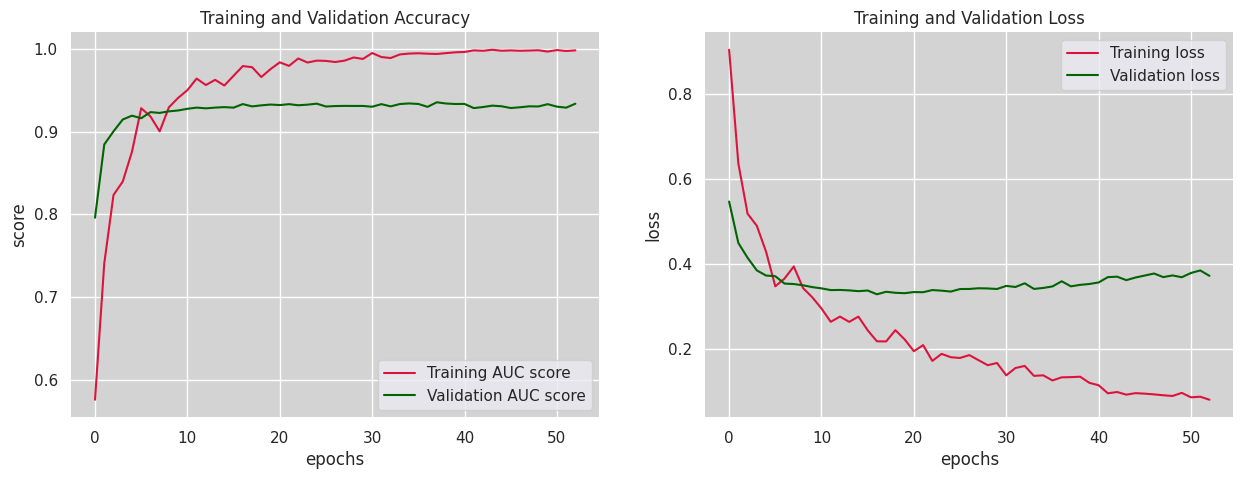

In [ ]:
plot_acc_loss_graphs(mobileNet_model)

## Evaluation

In [ ]:
#save model
mobileNet_model.save('/content/drive/MyDrive/All mixed/cls/wsl/round1/mobileNet_model_01.h5')

In [ ]:
#load saved model:
saved_mobileNet_model = tf.keras.models.load_model('/content/drive/MyDrive/All mixed/cls/wsl/round1/mobileNet_model_01.h5');

In [ ]:
#predict
y_pred_mn = mobileNet_model.predict(ds_test_mn, verbose=1)
print(f'y_pred_shape:{y_pred_mn.shape} and shape[0] is: {y_pred_mn.shape[0]}')

1/1 [==============================] - 7s 7s/step
y_pred_shape:(262, 2) and shape[0] is: 262


              precision    recall  f1-score   support

      benign       0.82      0.89      0.86       131
   malignant       0.88      0.81      0.84       131

   micro avg       0.85      0.85      0.85       262
   macro avg       0.85      0.85      0.85       262
weighted avg       0.85      0.85      0.85       262
 samples avg       0.85      0.85      0.85       262



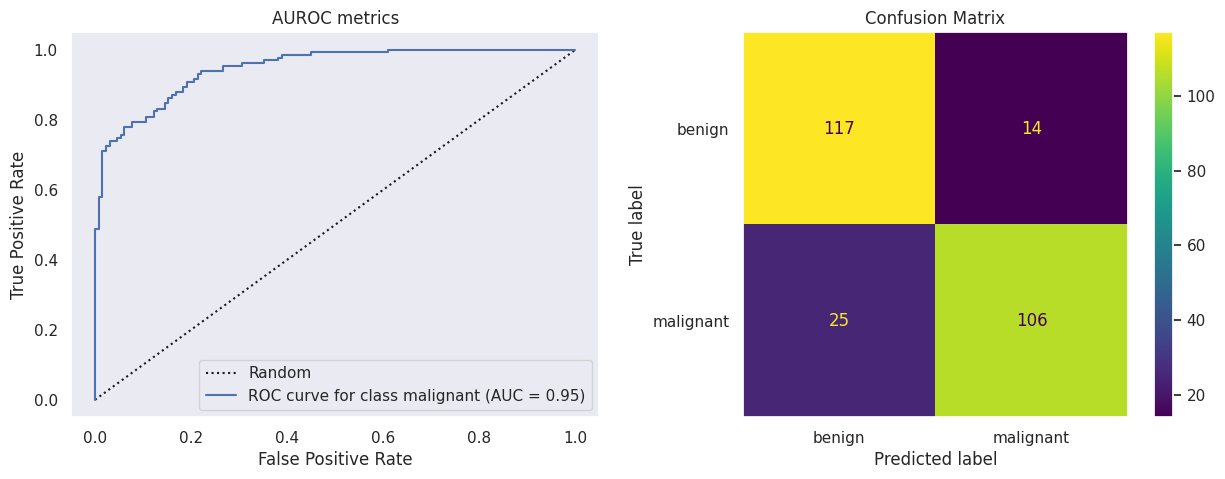

In [ ]:
plot_evaluation_graphs(y_pred_mn, ds_test_mn)

##View sample images

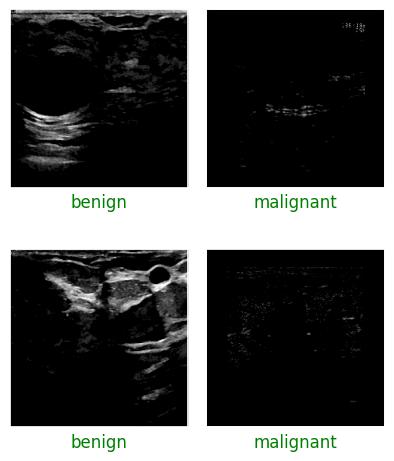

In [ ]:
#view sample images
image_mn, label_mn = ds_test_mn.next()
view_2_images(image_mn, label_mn, y_pred_mn, classes)

##Smaller Generators - TAKEN

###Create and preprocess datasets

In [ ]:
# def preprocess_mn(images, labels):
#   return tf.keras.applications.mobilenet.preprocess_input(images), labels

In [ ]:
ds_train_sm_mn, ds_val_sm_mn = generators_train_val((224,224), tf.keras.applications.mobilenet.preprocess_input, train_dir, val_dir, 10)
ds_test_sm_mn = generator_test((224,224), tf.keras.applications.mobilenet.preprocess_input, test_dir, 262)

Found 260 images belonging to 2 classes.
Found 134 images belonging to 2 classes.
Found 262 images belonging to 2 classes.


###Train

In [ ]:
pre_trained_model_mn= Sequential();

pre_trained_model_mn = tf.keras.applications.MobileNet(input_shape=(224,224, 3),  ##
                             include_top = False,
                             weights = 'imagenet',
                             pooling='avg',
                             classes=2
                             )

# Freeze layers
for layer in pre_trained_model_mn.layers: ##
  layer.trainable = False

x = pre_trained_model_mn.output ##
x = layers.Flatten()(x)
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dense(512, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
x = layers.Dense(60, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output= layers.Dense(class_count, activation='softmax')(x)

#mobile model
mobileNet_model = Model(pre_trained_model_mn.input, output) ##

In [ ]:
# Compile model
mobileNet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[AUC(name='auc')]
              )

# Train model
mobileNet_model.fit(ds_train_sm_mn, ##
          validation_data=ds_val_sm_mn, ##
          epochs=200,
          # callbacks=callback_params,
          # class_weight=class_weights,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=15),
                    #  tf.keras.callbacks.ModelCheckpoint('models/mobileNet_ai_{val_auc:.3f}.h5',
                    #                                     save_best_only=True,
                    #                                     save_weights_only=False,
                    #                                     monitor='val_auc')
                     ]
          )

Epoch 1/200
26/26 [==============================] - 8s 138ms/step - loss: 0.8064 - auc: 0.6464 - val_loss: 0.5324 - val_auc: 0.8074
Epoch 2/200
26/26 [==============================] - 3s 102ms/step - loss: 0.7054 - auc: 0.7166 - val_loss: 0.4489 - val_auc: 0.8748
Epoch 3/200
26/26 [==============================] - 2s 88ms/step - loss: 0.4792 - auc: 0.8574 - val_loss: 0.4138 - val_auc: 0.8959
Epoch 4/200
26/26 [==============================] - 2s 92ms/step - loss: 0.4308 - auc: 0.8797 - val_loss: 0.3965 - val_auc: 0.9058
Epoch 5/200
26/26 [==============================] - 2s 86ms/step - loss: 0.4099 - auc: 0.8927 - val_loss: 0.3736 - val_auc: 0.9184
Epoch 6/200
26/26 [==============================] - 3s 107ms/step - loss: 0.3366 - auc: 0.9303 - val_loss: 0.3688 - val_auc: 0.9169
Epoch 7/200
26/26 [==============================] - 3s 123ms/step - loss: 0.3512 - auc: 0.9218 - val_loss: 0.3602 - val_auc: 0.9212
Epoch 8/200
26/26 [==============================] - 2s 91ms/step - loss

In [ ]:
##save model
# resnet_model.save('/content/drive/MyDrive/Research/models/resnet_model_ai.h5')
# Assuming 'model' is your TensorFlow model
mobileNet_model.save("/content/drive/MyDrive/All mixed/cls/wsl/round1/mobileNet_model_sm_03.h5")
#load the model:
# saved_resnet_model = tf.keras.models.load_model('/content/drive/MyDrive/Research/models/resnet_model_ai.h5');

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


###Performance

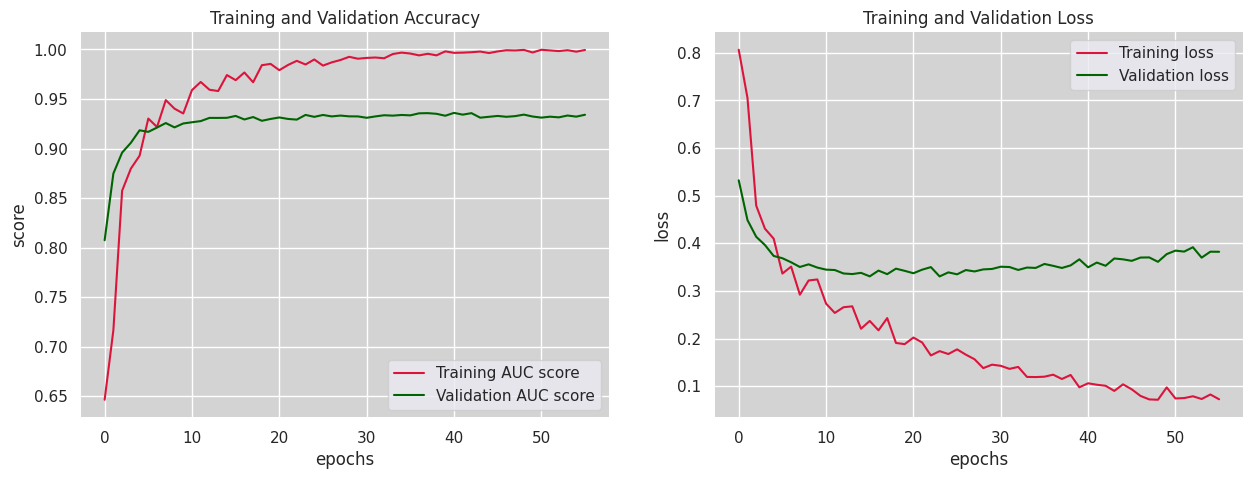

In [ ]:
plot_acc_loss_graphs(mobileNet_model)

### Evaluation

In [ ]:
#save model
#mobileNet_model.save('/content/drive/MyDrive/Research/models/mobileNet_model_03.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#load saved model:
saved_mobileNet_model = tf.keras.models.load_model('/content/drive/MyDrive/All mixed/cls/wsl/round1/mobileNet_model_sm_03.h5');
#saved_mobileNet_model2 = tf.keras.models.load_model('/content/drive/MyDrive/Research/models/mobileNet_model_sm_01.h5');
#saved_mobileNet_model3 = tf.keras.models.load_model('/content/drive/MyDrive/Research/models/mobileNet_model_sm_02.h5');

In [ ]:
#predict
y_pred_mn = saved_mobileNet_model.predict(ds_test_sm_mn, verbose=1)
print(f'y_pred_shape:{y_pred_mn.shape} and shape[0] is: {y_pred_mn.shape[0]}')

1/1 [==============================] - 2s 2s/step
y_pred_shape:(262, 2) and shape[0] is: 262


              precision    recall  f1-score   support

      benign       0.84      0.89      0.86       131
   malignant       0.88      0.83      0.85       131

   micro avg       0.86      0.86      0.86       262
   macro avg       0.86      0.86      0.86       262
weighted avg       0.86      0.86      0.86       262
 samples avg       0.86      0.86      0.86       262



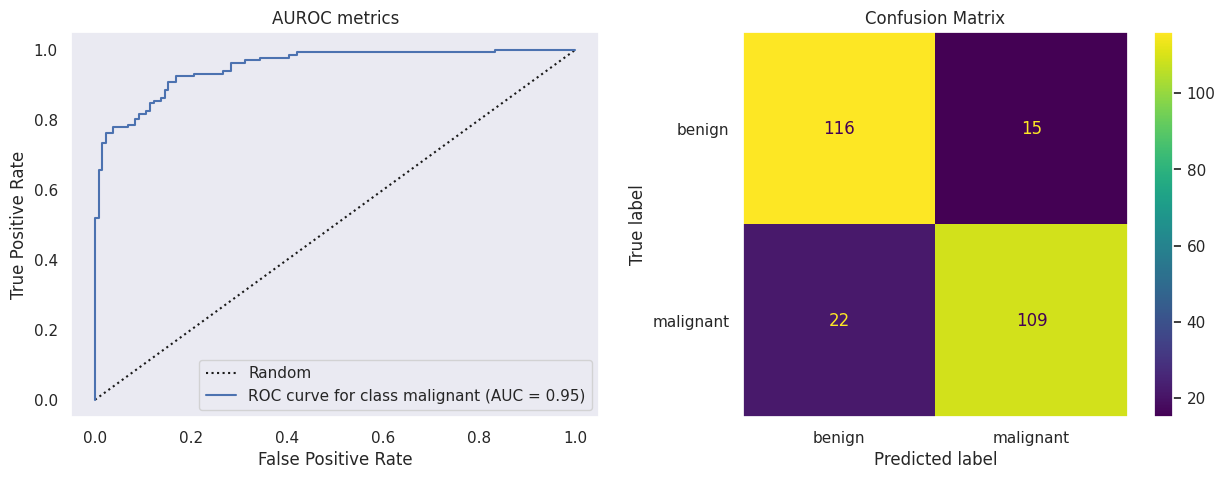

In [ ]:
plot_evaluation_graphs(y_pred_mn, ds_test_sm_mn)

#**WSL ROUND TWO**

#ResNet50

##Setup folders

In [ ]:
rn_train_dir_r2='/content/drive/MyDrive/All mixed/cls/wsl/round2/ResNet50 train'
rn_val_dir_r2='/content/drive/MyDrive/All mixed/cls/wsl/round1/val'
rn_test_dir_r2='/content/drive/MyDrive/All mixed/cls/wsl/round2/test'

## Separate Predictions

In [ ]:
rn_df_results = get_dataframe_results(y_pred_rn, resnet_model, ds_test_rn)


1/1 [==============================] - 2s 2s/step


In [ ]:
rn_df_results.Predicted_Class.value_counts()

Predicted_Class
0    139
1    123
Name: count, dtype: int64

In [ ]:
#separate predictions into folder for training
rn_folder_b = '/content/drive/MyDrive/All mixed/cls/wsl/round2/ResNet50 train/benign'
rn_folder_m = '/content/drive/MyDrive/All mixed/cls/wsl/round2/ResNet50 train/malignant'

#move_predicted_images_into_folders(rn_folder_b, rn_folder_m, rn_df_results)

Images moved successfully.


In [ ]:
#mix with original test data
src='/content/drive/MyDrive/All mixed/cls/wsl/round1/train/malignant'
dst = '/content/drive/MyDrive/All mixed/cls/wsl/round2/ResNet50 train/malignant'
#copy_jpg_images(src, dst)

Images copied successfully.


In [ ]:
#mix with original test data
src='/content/drive/MyDrive/All mixed/cls/wsl/round1/train/benign'
dst = '/content/drive/MyDrive/All mixed/cls/wsl/round2/ResNet50 train/benign'
#copy_jpg_images(src, dst)

Images copied successfully.


In [ ]:
count_images(rn_train_dir_r2)
count_images(rn_val_dir_r2)
count_images(rn_test_dir_r2)

253 files in subdirectory malignant.
269 files in subdirectory benign.
Total: 522 files.
67 files in subdirectory malignant.
67 files in subdirectory benign.
Total: 134 files.
35 files in subdirectory benign.
35 files in subdirectory malignant.
Total: 70 files.


##Smaller generator - TAKEN

####Create and preprocess datasets

In [ ]:
#preprocess the datasets
ds_train_sm_rn_r2, ds_val_sm_rn_r2 = generators_train_val((224,224), preprocess_input, rn_train_dir_r2, rn_val_dir_r2, 10)
ds_test_sm_rn_r2 = generator_test((224,224), preprocess_input, rn_test_dir_r2, 70)

Found 522 images belonging to 2 classes.
Found 134 images belonging to 2 classes.
Found 70 images belonging to 2 classes.


####Train, Compile & Fit Model

In [ ]:
pre_trained_model_rs = Sequential();

pre_trained_model_rs = ResNet50(input_shape=(224,224, 3),
                             include_top = False,
                             weights = 'imagenet',
                             pooling='avg',
                             classes=2
                             )

In [ ]:
# Freeze layers
for layer in pre_trained_model_rs.layers:
  layer.trainable = False

x = pre_trained_model_rs.output
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(356, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(class_count, activation='softmax')(x)

#resnet50 model
resnet_model = Model(inputs=pre_trained_model_rs.input, outputs=output)

In [ ]:
#model architecture
resnet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
# Compile model
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[AUC(name='auc')]
              )

# Train model
resnet_model.fit(ds_train_sm_rn_r2,
          validation_data=ds_val_sm_rn_r2,
          epochs=200,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=15),
                    #  tf.keras.callbacks.ModelCheckpoint(monitor='val_auc')
                     ]
          )

Epoch 1/200
53/53 [==============================] - 13s 126ms/step - loss: 14.3948 - auc: 0.4651 - val_loss: 13.3265 - val_auc: 0.7464
Epoch 2/200
53/53 [==============================] - 7s 135ms/step - loss: 13.4583 - auc: 0.4995 - val_loss: 12.7619 - val_auc: 0.7743
Epoch 3/200
53/53 [==============================] - 7s 132ms/step - loss: 12.7280 - auc: 0.5338 - val_loss: 12.2710 - val_auc: 0.7611
Epoch 4/200
53/53 [==============================] - 5s 98ms/step - loss: 12.2644 - auc: 0.5050 - val_loss: 11.8151 - val_auc: 0.8319
Epoch 5/200
53/53 [==============================] - 7s 128ms/step - loss: 11.8614 - auc: 0.4689 - val_loss: 11.4294 - val_auc: 0.8167
Epoch 6/200
53/53 [==============================] - 5s 97ms/step - loss: 11.4074 - auc: 0.5130 - val_loss: 11.0562 - val_auc: 0.8242
Epoch 7/200
53/53 [==============================] - 7s 140ms/step - loss: 10.9860 - auc: 0.5751 - val_loss: 10.7181 - val_auc: 0.8123
Epoch 8/200
53/53 [==============================] - 5s 

####Performance

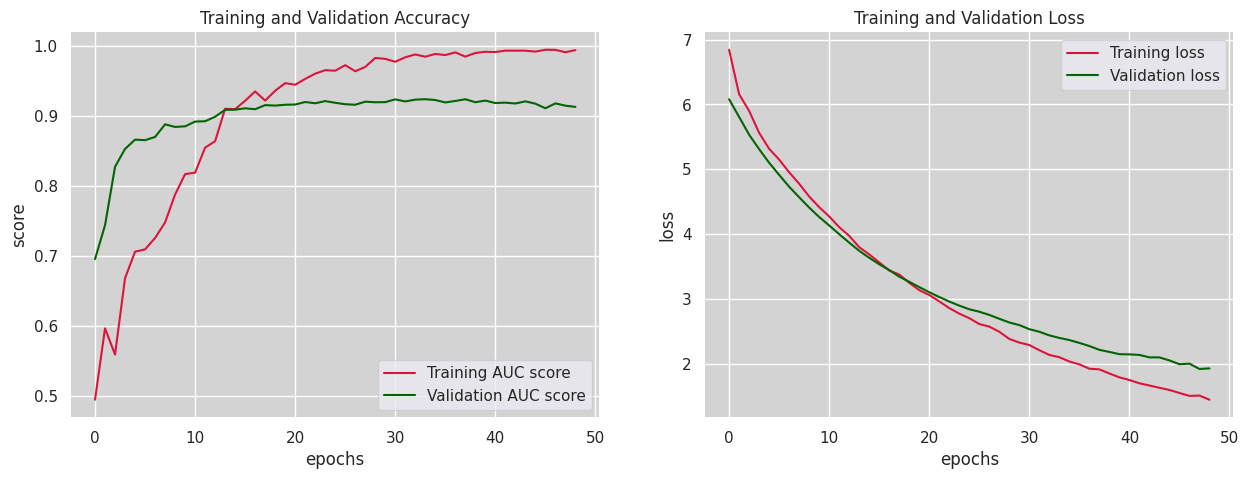

In [ ]:
plot_acc_loss_graphs(resnet_model)

####Evaluation

In [ ]:
!pwd

/content


In [ ]:
##Evaluation
resnet_model.save('/content/drive/MyDrive/All mixed/cls/wsl/round2/resnet50_sm_wsl_r2_model_05.h5')
# Assuming 'model' is your TensorFlow model
# resnet_model.save("/content/drive/MyDrive/Research/models/resnet50_sm_wsl_model_03.h5")
#load the model:
saved_resnet_r2_model = tf.keras.models.load_model('/content/drive/MyDrive/All mixed/cls/wsl/round2/resnet50_sm_wsl_r2_model_05.h5');

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
y_pred_rn_r2 = saved_resnet_r2_model.predict(ds_test_sm_rn_r2, verbose=1)
print(f'y_pred_shape:{y_pred_rn_r2.shape} and shape[0] is: {y_pred_rn_r2.shape[0]}')

1/1 [==============================] - 0s 495ms/step
y_pred_shape:(70, 2) and shape[0] is: 70


              precision    recall  f1-score   support

      benign       0.56      0.57      0.56        35
   malignant       0.56      0.54      0.55        35

   micro avg       0.56      0.56      0.56        70
   macro avg       0.56      0.56      0.56        70
weighted avg       0.56      0.56      0.56        70
 samples avg       0.56      0.56      0.56        70



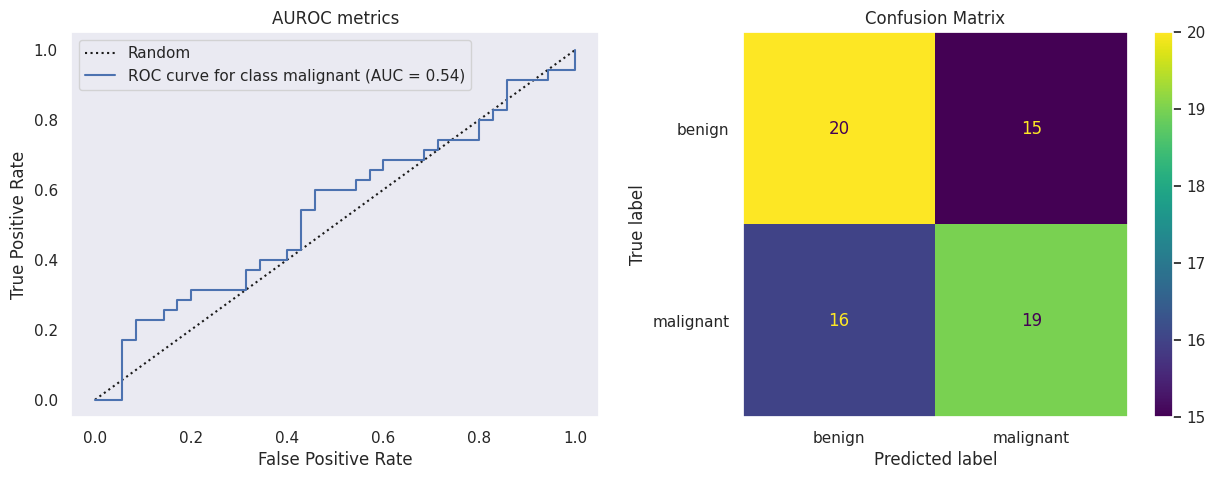

In [ ]:
plot_evaluation_graphs(y_pred_rn_r2, ds_test_sm_rn_r2)

#MobileNet

##Setup for round 2

In [ ]:
#setup for round 2
mn_train_dir_r2='/content/drive/MyDrive/All mixed/cls/wsl/round2/mobileNet train'
mn_val_dir_r2='/content/drive/MyDrive/All mixed/cls/wsl/round2/val'
mn_test_dir_r2='/content/drive/MyDrive/All mixed/cls/wsl/round2/test'

In [ ]:
y_pred_mn.shape

(262, 2)

### Separate Predictions

In [ ]:
mn_df_results = get_dataframe_results(y_pred_mn, saved_mobileNet_model, ds_test_sm_mn)


1/1 [==============================] - 1s 1s/step


In [ ]:
mn_df_results.Predicted_Class.value_counts()

Predicted_Class
0    138
1    124
Name: count, dtype: int64

In [ ]:
#separate predictions into folder for training
mn_folder_b = '/content/drive/MyDrive/All mixed/cls/wsl/round2/mobileNet train/benign'
mn_folder_m = '/content/drive/MyDrive/All mixed/cls/wsl/round2/mobileNet train/malignant'

move_predicted_images_into_folders(mn_folder_b, mn_folder_m, mn_df_results)

Images moved successfully.


In [ ]:
#mix with original test data
src='/content/drive/MyDrive/All mixed/cls/wsl/round1/train/malignant'
dst = '/content/drive/MyDrive/All mixed/cls/wsl/round2/mobileNet train/malignant'
copy_jpg_images(src, dst)

Images copied successfully.


In [ ]:
#mix with original test data
src='/content/drive/MyDrive/All mixed/cls/wsl/round1/train/benign'
dst = '/content/drive/MyDrive/All mixed/cls/wsl/round2/mobileNet train/benign'
copy_jpg_images(src, dst)

Images copied successfully.


In [ ]:
count_images(mn_train_dir_r2)
count_images(mn_val_dir_r2)
count_images(mn_test_dir_r2)

130 files in subdirectory benign.
254 files in subdirectory malignant.
Total: 1400 files.
67 files in subdirectory malignant.
67 files in subdirectory benign.
Total: 134 files.
35 files in subdirectory benign.
35 files in subdirectory malignant.
Total: 70 files.


##Smaller Generators -TAKEN

###Create and preprocess datasets

In [ ]:
# def preprocess_mn(images, labels):
#   return tf.keras.applications.mobilenet.preprocess_input(images), labels

In [ ]:
ds_train_sm_mn_r2, ds_val_sm_mn_r2 = generators_train_val((224,224), tf.keras.applications.mobilenet.preprocess_input, mn_train_dir_r2, mn_val_dir_r2, 8)
ds_test_sm_mn_r2 = generator_test((224,224), tf.keras.applications.mobilenet.preprocess_input, mn_test_dir_r2, 262)

Found 384 images belonging to 2 classes.
Found 134 images belonging to 2 classes.
Found 70 images belonging to 2 classes.


###Train

In [ ]:
from tensorflow.keras import regularizers
pre_trained_model_mn= Sequential();

pre_trained_model_mn = tf.keras.applications.MobileNet(input_shape=(224,224, 3),  ##
                             include_top = False,
                             weights = 'imagenet',
                             pooling='avg',
                             classes=2
                             )

# Freeze layers
for layer in pre_trained_model_mn.layers: ##
  layer.trainable = False
x = pre_trained_model_mn.output
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(class_count, activation='softmax')(x)

#mobile model
mobileNet_model = Model(pre_trained_model_mn.input, output) ##

17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
# Compile model
mobileNet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[AUC(name='auc')]
              )

# Train model
mobileNet_model.fit(ds_train_sm_mn, ##
          validation_data=ds_val_sm_mn, ##
          epochs=200,
          # callbacks=callback_params,
          # class_weight=class_weights,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=15),
                    #  tf.keras.callbacks.ModelCheckpoint('models/mobileNet_ai_{val_auc:.3f}.h5',
                    #                                     save_best_only=True,
                    #                                     save_weights_only=False,
                    #                                     monitor='val_auc')
                     ]
          )

Epoch 1/200
26/26 [==============================] - 6s 111ms/step - loss: 8.9699 - auc: 0.5745 - val_loss: 6.9257 - val_auc: 0.8841
Epoch 2/200
26/26 [==============================] - 2s 90ms/step - loss: 6.4070 - auc: 0.6769 - val_loss: 5.3850 - val_auc: 0.9122
Epoch 3/200
26/26 [==============================] - 3s 125ms/step - loss: 4.9776 - auc: 0.8187 - val_loss: 4.4083 - val_auc: 0.9164
Epoch 4/200
26/26 [==============================] - 2s 96ms/step - loss: 4.1563 - auc: 0.8675 - val_loss: 3.7863 - val_auc: 0.9307
Epoch 5/200
26/26 [==============================] - 2s 86ms/step - loss: 3.5511 - auc: 0.8982 - val_loss: 3.2551 - val_auc: 0.9270
Epoch 6/200
26/26 [==============================] - 2s 87ms/step - loss: 3.1069 - auc: 0.9137 - val_loss: 2.9045 - val_auc: 0.9218
Epoch 7/200
26/26 [==============================] - 2s 86ms/step - loss: 2.7315 - auc: 0.9259 - val_loss: 2.5648 - val_auc: 0.9322
Epoch 8/200
26/26 [==============================] - 3s 101ms/step - loss:

In [ ]:
##save model
# resnet_model.save('/content/drive/MyDrive/Research/models/resnet_model_ai.h5')
# Assuming 'model' is your TensorFlow model
mobileNet_model.save("/content/drive/MyDrive/All mixed/cls/wsl/round2/mobileNet train/mobileNet_model_sm_wsl_r2_03.h5")
#load the model:
# saved_resnet_model = tf.keras.models.load_model('/content/drive/MyDrive/Research/models/resnet_model_ai.h5');

###Performance

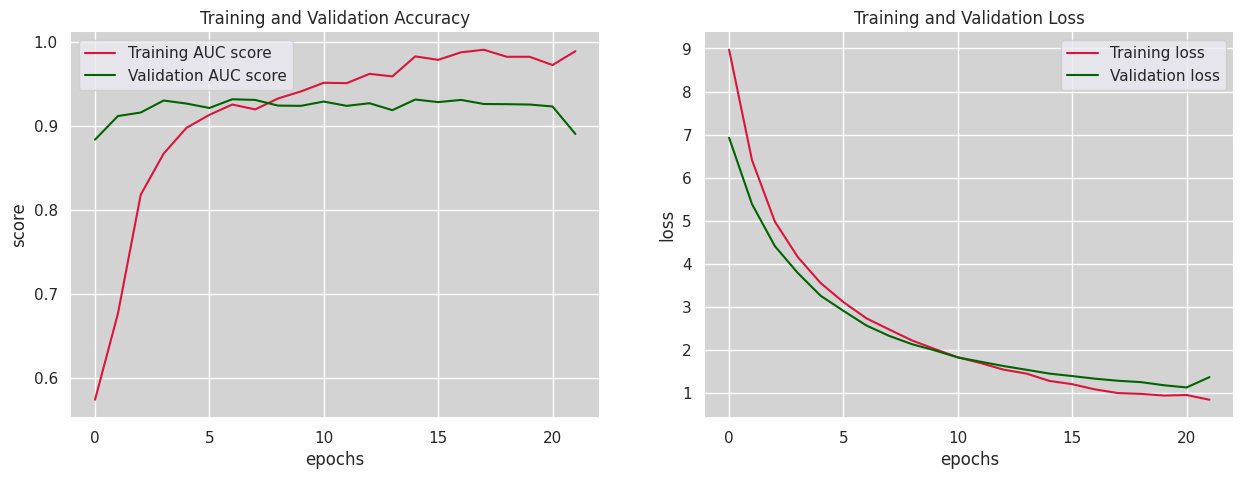

In [ ]:
plot_acc_loss_graphs(mobileNet_model)

### Evaluation

In [ ]:
#save model
# mobileNet_model.save('/content/drive/MyDrive/Research/models/mobileNet_model_03.h5')

In [ ]:
#load saved model:
saved_mobileNet_model = tf.keras.models.load_model("/content/drive/MyDrive/All mixed/cls/wsl/round2/mobileNet train/mobileNet_model_sm_wsl_r2_02.h5");

In [ ]:
#predict
y_pred_mn_r2 = saved_mobileNet_model.predict(ds_test_sm_mn_r2, verbose=1)
print(f'y_pred_shape:{y_pred_mn_r2.shape} and shape[0] is: {y_pred_mn_r2.shape[0]}')

1/1 [==============================] - 1s 794ms/step
y_pred_shape:(70, 2) and shape[0] is: 70


              precision    recall  f1-score   support

      benign       0.53      0.66      0.59        35
   malignant       0.56      0.43      0.48        35

   micro avg       0.54      0.54      0.54        70
   macro avg       0.55      0.54      0.54        70
weighted avg       0.55      0.54      0.54        70
 samples avg       0.54      0.54      0.54        70



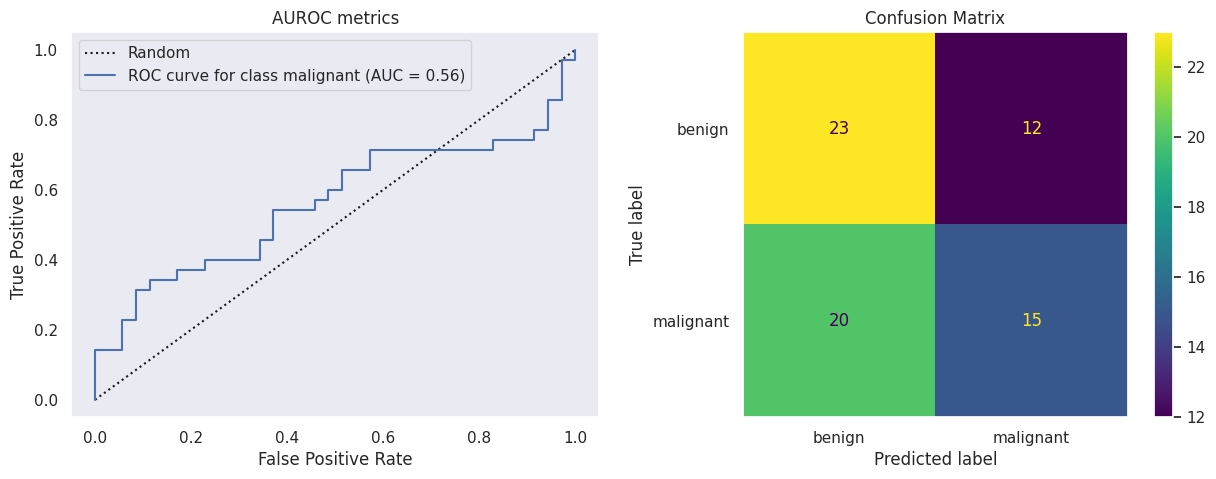

In [ ]:
plot_evaluation_graphs(y_pred_mn_r2, ds_test_sm_mn_r2)